In [9]:
import os
import subprocess
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
from scipy.stats import linregress
import math
from datetime import datetime
import dill
import seaborn as sns
import statistics
import sys
import numpy as np
import math
import os
import subprocess
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
from scipy.stats import linregress
import math
from datetime import datetime
import dill
import seaborn as sns
from sklearn.metrics import mutual_info_score
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import ipyparallel as ipp
import pickle

def getDistanceV2(X,d,lag,point1,point2):
    summary = 0
    for i in range(0,d*lag+1,lag):
        summary += (X[point1 + i] - X[point2 + i])**2
    summary = math.sqrt(summary)
    return summary

def simplex_projection(data,d,lag,prediction_steps,neighbor_numbers):
    # data is 1D scalar temporal
    neighbors_distance = []
    neighbors_index = []
    
    for ii,i in enumerate(range(int(len(data) / 2), len(data) - 1 - d * lag  - prediction_steps)):
        neighbors_distance.append(np.full(neighbor_numbers,1e10))
        neighbors_index.append(np.zeros(neighbor_numbers))
        for j in range(int(len(data) / 2) - 1 - d * lag  - prediction_steps):
            distance = getDistanceV2(data,d,lag,i,j)
            if distance < max(neighbors_distance[ii]):
                max_index = np.argmax(neighbors_distance[ii])
                neighbors_distance[ii][max_index] = distance
                neighbors_index[ii][max_index] = j
    
    prediction = []
    observation = []
    
    for step in range(prediction_steps):
        observation.append([])
        prediction.append([])
        for ii,i in enumerate(range(int(len(data) / 2), len(data) - 1 - d * lag  - prediction_steps)):
            observation[step].append(data[int(i + d*lag + step + 1)])
            cur_prediction = 0
            total_weight = 0
            
            for neighbor in neighbors_index[ii]:
                cur_prediction += (1 / getDistanceV2(data,d,lag,i,j)) * data[int(neighbor + d*lag + step + 1)]
                total_weight += (1 / getDistanceV2(data,d,lag,i,j))
                
            cur_prediction /= total_weight
            prediction[step].append(cur_prediction)
    return prediction,observation
def avg(lya):
    result = []
    err = []
    
    for j in range(len(lya[0][0])):
        result.append([])
        err.append([])
        value = []      
        for i in range(len(lya)):
            if lya[i][0][j]!= float("inf"):
                value.append(lya[i][0][j])

        result[j] = sum(value)/len(value)
        err[j] = np.std(value)       
    return result,err

def avg_repeat(lya):
    result = []
    err = []
    
    for j in range(len(lya[0][0])):
        result.append([])
        err.append([])
        value = []   
        for k in range(len(lya)):
            for i in range(len(lya[0])):
                if lya[k][i][j][0]!= float("inf"):
                    value.append(lya[k][i][j][0])

        result[j] = sum(value)/len(value)
        err[j] = np.std(value)       
    return result,err

def avg_repeat2(lya):
    result = []
    err = []
    
    for j in range(len(lya[0][0][0])):
        result.append([])
        err.append([])
        value = []   
        for k in range(len(lya)):
            for i in range(len(lya[0])):
                if lya[k][i][0][j]!= float("inf"):
                    value.append(lya[k][i][0][j])

        result[j] = sum(value)/len(value)
        err[j] = np.std(value)       
    return result,err

def avg_taupw(lya):
    result = []
    err = []
    
    for j in range(len(lya[0])):
        result.append([])
        err.append([])
        value = []      
        for i in range(len(lya)):
            if lya[i][j][0]!= float("inf"):
                value.append(lya[i][j][0])

        result[j] = sum(value)/len(value)
        err[j] = np.std(value)       
    return result,err
def linear_interpolation(y0,y1,x0,x1,x):
    
    return (y0 * (x1-x) + y1 * (x-x0)) / (x1-x0)
def get_APD_and_voltage_new(path,threshhold,dt):
    
    number_of_points = 0
    end_of_first_dt = False
    data = []
    
    with open(path) as csv_file: # totally 501 points
        csv_reader = csv.reader(csv_file, delimiter=',')
        
        for row in csv_reader:
            for i in range(len(row)):
                for j in row[i]:
                    if j == ';':
                        row[i] = row[i].replace(';', '')
                        if end_of_first_dt == False:
                            end_of_first_dt = True
                            number_of_points = i
                if row[i] != '':           
                    data.append(float(row[i]))                
    if (len(data)/number_of_points).is_integer():
        rows, cols=number_of_points,int(len(data)/number_of_points)
    else:
        print('error! non-integar time steps')     

    voltage = np.zeros([rows,cols])

    for i in range(rows):
        for j in range(cols):

            voltage[i][j] = data[j * rows +  i]
         
    APD = []
    # linear interpolation 
    APD_start_error = -100
    APD_end_error = -100    


    for i in range(number_of_points):
        APD.append([])
        
        APD_value = 0
        start_apd = False
        
        for j in range(len(voltage[0])):


            if j != 0 and start_apd == False and voltage[i][j] > threshhold   and j+1 < len(voltage[0]) and voltage[i][j+1] > threshhold:
                start_apd = True
                APD_start_error = linear_interpolation(1,0,voltage[i][j],voltage[i][j-1],threshhold)
                APD_start_error = 1 - APD_start_error

            if start_apd == True and voltage[i][j] <= threshhold and j+1 < len(voltage[0]) and voltage[i][j+1] <= threshhold: 
                start_apd = False
                APD_end_error = linear_interpolation(0,-1,voltage[i][j],voltage[i][j-1],threshhold)
                
                # linear interpolation 
                APD_value += (APD_start_error + APD_end_error) * dt
 
                
                APD[i].append(APD_value)
            
                APD_value = 0
                APD_start_error = -100
                APD_end_error = -100 
                
            if start_apd == True:
                APD_value += dt
        
        # trim first incomplete APD
        if voltage[i][1] > threshhold and voltage[i][2] > threshhold:
            APD[i].pop(0)
    
    return APD,voltage
def get_APD_and_voltage_uvw(path,threshhold,dt,scale = False):
    
    number_of_points = 0
    end_of_first_dt = False
    
    data = []
    with open(path) as csv_file: # totally 501 points
        csv_reader = csv.reader(csv_file, delimiter=',')
        
        for row in csv_reader:
            for i in range(len(row)):
                for j in row[i]:
                    if j == ';':
                        row[i] = row[i].replace(';', '')
                        if end_of_first_dt == False:
                            end_of_first_dt = True
                            number_of_points = i
                        
                if row[i] != '' and i%4 != 0: 
                    data.append(float(row[i]))    
    max_value = max(data)
    min_value = min(data)
    if scale == True:
        for i in range(len(data)):
            data[i] = (data[i] - min_value) / (max_value - min_value)

    # if we input whole texture
    if (number_of_points * 3 / 4).is_integer():
        number_of_points = int( number_of_points * 3 / 4)
    else:
        print('error! non-integar number of points')
    # if we input whole texture
    
    if (len(data)/number_of_points).is_integer():
        rows, cols=number_of_points,int(len(data)/number_of_points)
    else:
        print('error! non-integar time steps',len(data),number_of_points) 
        
    voltage = np.zeros([rows,cols])

    for i in range(rows):
        for j in range(cols):

            voltage[i][j] = data[j * rows +  i]

    print(number_of_points)
    
    APD = []
    # linear interpolation 
    APD_start_error = -100
    APD_end_error = -100    


    for i in range(number_of_points):
        APD.append([])
        
        APD_value = 0
        start_apd = False

        if i % 3 != 2 :
        
            for j in range(len(voltage[0])):
    
    
                if j != 0 and start_apd == False and voltage[i][j] > threshhold   and j+1 < len(voltage[0]) and voltage[i][j+1] > threshhold:
                    start_apd = True
                    
                    if j%4 == 0 and abs(voltage[i][j] - voltage[i][j-1]) < 1e-9:
                        print(i,j)
                        print( voltage[i])
                        sys.exit()
                    APD_start_error = linear_interpolation(1,0,voltage[i][j],voltage[i][j-1],threshhold)
                    APD_start_error = 1 - APD_start_error
    
                if start_apd == True and voltage[i][j] < threshhold and j+1 < len(voltage[0]) and voltage[i][j+1] < threshhold: 
                    start_apd = False
                    APD_end_error = linear_interpolation(0,-1,voltage[i][j],voltage[i][j-1],threshhold)
                    
                    # linear interpolation 
                    APD_value += (APD_start_error + APD_end_error) * dt
     
                    
                    APD[i].append(APD_value)
                
                    APD_value = 0
                    APD_start_error = -100
                    APD_end_error = -100 
                    
                if start_apd == True:
                    APD_value += dt
            
            # trim first incomplete APD
            if voltage[i][1] > threshhold and voltage[i][2] > threshhold and len(APD[i]) > 0:
                APD[i].pop(0)
            
    APD_u = []
    APD_v = []
    #APD_w = []
    voltage_u = []
    voltage_v = []
    voltage_w = []

    for i in range(len(APD)):
        if (i+1) % 3 == 1:
            APD_u.append(APD[i])
            voltage_u.append(voltage[i])
        if (i+1) % 3 == 2:
            APD_v.append(APD[i])
            voltage_v.append(voltage[i])
        if (i+1) % 3 == 0:
            #APD_w.append(APD[i])
            voltage_w.append(voltage[i])

    APD_uvw = [APD_u,APD_v]#,APD_w]
    voltage_uvw = [voltage_u,voltage_v,voltage_w]
    
    return APD_uvw,voltage_uvw
    



def embed_data(data,m,tau=1):
    
    embedded_data = np.zeros([len(data) - m*tau,m])
    
    for i in range(len(data) - m*tau):
        for j in range(m):
            embedded_data[i][j] = data[i + j*tau]
    return embedded_data


def euclidian_distance(X,Y):
    dis = 0
    for i in range(len(X)):
        dis += (X[i] - Y[i])**2
    return np.sqrt(dis)

def magnitude(X): 
    magnitude = 0
    for i in range(len(X)):
        magnitude += X[i]**2
    return np.sqrt(magnitude)

def angle(X,Y):
    
    return math.acos(round( np.dot(X, Y) / ( magnitude(X) * magnitude(Y) )  , 7) )

def find_nearest_neighbor(embedded_data,cur_point,epsilon,theta,boundary):
    
    length = len(embedded_data)
    dim = len(embedded_data[0])
    
    dis = 1e8
    nearest_Y_index = 1e8
    X = embedded_data[cur_point]
    
    for i in range(int(length - boundary)):
        Y = embedded_data[i]
        if i != cur_point and euclidian_distance(X,Y) < dis and angle(X,Y) < theta:
            dis = euclidian_distance(X,Y)
            nearest_Y_index = i
    
    if dis < epsilon:
        return dis,nearest_Y_index
    else:
        print("cannot find neighbor for point ", cur_point, ',dis = ', dis)
        return False
    
def find_L_and_evolve_point(embedded_data,cur_point,epsilon,theta,boundary):
    
    L0 = 0
    L0_prime = 0
    
    length = len(embedded_data)
    dim = len(embedded_data[0])
    
    x = embedded_data[cur_point]
    
    result = find_nearest_neighbor(embedded_data,cur_point,epsilon,theta,boundary)
    
    while result == False:
        return False

    
    neighbor_point = result[1]
    z = embedded_data[neighbor_point]

    
    L0 =  result[0]
    L0_prime = result[0]
    
    step = 0
    while L0_prime < epsilon and (cur_point + step) < length and (neighbor_point + step) < length:

        
        '''
        if cur_point + step >= length:
            if cur_point < (3/4 * length):
                print("cur_point + step >= length",embedded_data[cur_point + step] , embedded_data[neighbor_point + step],cur_point )
            return False
        '''
        x = embedded_data[cur_point + step]
        '''
        if neighbor_point + step >= length:
            print("neighbor_point + step >= length",embedded_data[cur_point + step] , embedded_data[neighbor_point + step],neighbor_point )
            return False
        '''
        z = embedded_data[neighbor_point + step]
        
        L0_prime = euclidian_distance(x,z)
        step += 1
        
    return np.log(L0_prime / L0) / np.log(2) , cur_point + step

    
def wolf_lya_exp(embedded_data,epsilon = 0.1,start_point = 'middle',theta = np.pi / 9,boundary = 1500):
    
    if start_point == 'middle':
        start_point = int(len(embedded_data) / 2) - boundary
    
    cur_point = start_point
    log_sum = 0
    
    while cur_point < len(embedded_data):
        
        result = find_L_and_evolve_point(embedded_data,cur_point,epsilon,theta,boundary)

        if result != False:     
            log_sum += result[0]
            cur_point = result[1]        
        
        if cur_point == start_point:
            start_point += 1
            cur_point = start_point           
            continue
        
        if result == False:
            break

        

    return log_sum /  (cur_point - start_point)


#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

def run_cmd(command): # cmd /k command
    
    
    
    command ='cmd /k \"' +  command + '\"'

    try:
        os.system(command)
        result = subprocess.check_output(command, shell=True, text=True)
        #print(result)        
        
    except:
        print('error os cmd')
        
def getDistance(X,i,d,k,h):
    summary = 0
    for j in range(i-1,i+d-1):
        summary += (X[j][k] - X[j][h])**2
    summary = math.sqrt(summary)
    return summary
def findPairs(X,i,d,k,h,e):
    if k == h:
        return False
    summary = getDistance(X,i,d,k,h)
    if summary < e and summary > 0:
        #print(summary)
        return True
    else:
        return False
def findLyp(X,d,e):
    lyp = 0
    Np = 0
    m = X.shape[0]
    L = X.shape[1]
    for jj in range(0,m-d):
        #print(jj)
        for kk in range(L):
            for hh in range(kk + 1,L):
                if findPairs(X,jj+1,d,kk,hh,e) == True and getDistance(X,jj+2,d,kk,hh) > 0:
                    Np += 1
                    lyp += math.log(getDistance(X,jj+2,d,kk,hh)/getDistance(X,jj+1,d,kk,hh))
                    #if (abs(lyp) > 1000):
                        #print(lyp,getDistance(jj+2,d,kk,hh),getDistance(jj+1,d,kk,hh),jj,kk,hh)

    if Np == 0:
        print('error')
        return
    lyp = lyp/Np
    #print("lyapunov exp is:",lyp,"\nnumber of pairs found:",Np)
    return lyp

def linear_interpolation(y0,y1,x0,x1,x):
    return (y0 * (x1-x) + y1 * (x-x0)) / (x1-x0)

def get_APD_and_voltage(tau_pw,tau_d,number_of_points,dt = 4,noise = False, noise_value_percentage = 0.1):
    
    tau_pw = str(tau_pw)
    tau_d = str(tau_d)
    data = []

    with open('tau_pw_' + tau_pw + '_tau_d_' + tau_d + '_spatial.csv') as csv_file: # totally 501 points
        csv_reader = csv.reader(csv_file, delimiter='.')
        for row in csv_reader:
            data.append(float(row[0] + '.' + row[1][:-1]))
            for i in range(1,len(row) - 1):
                for j in row[i + 1]:
                    if j == ';':
                        row[i + 1] = row[i + 1].replace(';', '')
                        
                if i == len(row) - 2:    
                    data.append(float(row[i][-1] + '.' + row[i + 1][:]))                    
                
                else:
                    data.append(float(row[i][-1] + '.' + row[i + 1][:-1]))
                    #r_03999.append(float(row[i]))                
    
    rows, cols=number_of_points,int(len(data)/number_of_points)
    voltage = np.zeros([rows,cols])

    for i in range(rows):
        for j in range(cols):

            voltage[i][j] = data[j * rows +  i]
         
    APD = []
    # linear interpolation 
    APD_start_error = -100
    APD_end_error = -100    


    for i in range(number_of_points):
        APD.append([])
        
        APD_value = 0
        start_apd = False
        
        for j in range(len(voltage[0])):


            if j != 0 and start_apd == False and voltage[i][j] > 0.3   and j+1 < len(voltage[0]) and voltage[i][j+1] > 0.3:
                start_apd = True
                APD_start_error = linear_interpolation(1,0,voltage[i][j],voltage[i][j-1],0.3)
                APD_start_error = 1 - APD_start_error

            if start_apd == True and voltage[i][j] <= 0.3 and j+1 < len(voltage[0]) and voltage[i][j+1] <= 0.3: 
                start_apd = False
                APD_end_error = linear_interpolation(0,-1,voltage[i][j],voltage[i][j-1],0.3)
                
                # linear interpolation 
                APD_value += (APD_start_error + APD_end_error) * dt
 
                
                APD[i].append(APD_value)
            
                APD_value = 0
                APD_start_error = -100
                APD_end_error = -100 
                
            if start_apd == True:
                APD_value += dt
        
        # trim first incomplete APD
        if voltage[i][1] > 0.3 and voltage[i][2] > 0.3:
            APD[i].pop(0)

        # add some percentage noise to APD data
        if noise == True:
            APD_averaged_for_i = sum(APD[i]) / len(APD[i])
            for APD_index_i in range(len(APD[i])):
                APD[i][APD_index_i] += 2 * np.round(random.uniform(-APD_averaged_for_i * noise_value_percentage, APD_averaged_for_i * noise_value_percentage) / 2)
                if APD[i][APD_index_i] < 0:
                    print("noise too large",APD[i][APD_index_i])
                    APD[i][APD_index_i] = 0
    
    return APD,voltage

def find_temp_lya_exp_growth_in_lyap_file(file_name,tisean_parameter):
    
    delta_s = []

        
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file)
        cur_eps_dim = False        
        for row in csv_reader:
            if row == [tisean_parameter]:
                cur_eps_dim = True
                continue
            
            if cur_eps_dim == True:
                
                if row == []:
                    break


                num = ''
                check_time = 0
                for i in row[0]:
                    if i == ' ':
                        check_time += 1
                        continue
                    if check_time == 1:
                        num += i
                num = float(num)
                delta_s.append(num) 
            else:
                continue
    return delta_s

def is_monotonic(arr):
    unique_elements = set(arr)
    increasing = sorted(arr) == arr or sorted(arr, reverse=True) == arr
    return increasing


def get_temporal_lya_exp(APD,how_many_temporal_lya_want,tau_pw,tau_d,r = 10, R = 50,s = 50,tisean_parameter = '#epsilon= 5.000000e+001  dim= 4',path = "D://Downloads/TISEAN_9_17"):
    
    tau_pw = str(tau_pw)
    tau_d = str(tau_d)
    
    temporal_lya_exp_list = [] # (lya exp)
    temporal_lya_exp_list_index = []
    


    point_index = list(range(len(APD)))

    random.shuffle(point_index)
    
    os.chdir(path)
    
    for i in point_index:

        # output the APD to dat file
        name = 'tau_pw_' + tau_pw + '_tau_d_' + tau_d + "_p" + str(i) + ".dat"
        f=open(name,"w")
        for line in APD[i]:
            f.write(str(line)+"\n")
        f.close()              


        # run tisean
        
        #if os.path.isfile(name + ".lyap") != True:
        
        command = 'lyap_k ' + name + ' -M4 -m3 -d1 -s' + str(s) + ' -r' + str(r) + ' -R' + str(R) +' -o'
        run_cmd(command)

        # examine if we have linear region for this point
        delta_s = find_temp_lya_exp_growth_in_lyap_file(name + ".lyap" , tisean_parameter)
        if delta_s != []:
            for linear_x_range in range(7,4,-1):
                if (is_monotonic(delta_s[:linear_x_range]) == True):
                    if delta_s[linear_x_range-1] > delta_s[0]:
                        if abs(min(delta_s[linear_x_range-1:]) - delta_s[linear_x_range-1]) < 0.1:
                            time = list(range(len(delta_s)))  

                            temporal_lya_exp_list.append(linregress(time[:linear_x_range],delta_s[:linear_x_range])[0])
                            temporal_lya_exp_list_index.append(i)
                          
                            break
        
                    elif delta_s[linear_x_range-1] < delta_s[0]:
                        if abs(max(delta_s[linear_x_range-1:]) - delta_s[linear_x_range-1]) < 0.1:
                            time = list(range(len(delta_s)))  

                            temporal_lya_exp_list.append(linregress(time[:linear_x_range],delta_s[:linear_x_range])[0])
                            temporal_lya_exp_list_index.append(i)  

                            break
                
                if len(temporal_lya_exp_list) >= how_many_temporal_lya_want:
                    return temporal_lya_exp_list,temporal_lya_exp_list_index            
                        
    return temporal_lya_exp_list,temporal_lya_exp_list_index 

def get_spatial_lya_exp(APD,number_of_points_used,spatial_dim = 4,spatial_diff = 3,repeat_time = 10):
    
    lyp_exp_list = []
    
    for repeat_time_i in range(repeat_time):
    
        shuffled_partial_APD = random.sample(APD, number_of_points_used)


        length = number_of_points_used

        min_minn = 3

        minn = 1e5
        for i in range(number_of_points_used):
            if len(shuffled_partial_APD[i]) < minn and len(shuffled_partial_APD[i]) > min_minn:
                minn = len(shuffled_partial_APD[i]) 
            if len(shuffled_partial_APD[i]) <= min_minn:
                length -= 1
                #print('zero apd detected')


        APD_consist = np.full((minn-1,length),-100) # [1:14]
        for i in range(length):
            for j in range(minn-1):
                if len(shuffled_partial_APD[i]) > min_minn:
                    APD_consist[j][i] = shuffled_partial_APD[i][j+1]
        lyp_exp = findLyp(APD_consist,spatial_dim,spatial_diff)     #  # taud = 0.41 
        
        if lyp_exp is not None:
            lyp_exp_list.append(lyp_exp)

        #print(lyp_exp,'minn',minn,'length',length,repeat_time_i,'\n')
    
    lyp_exp_averaged = sum(lyp_exp_list) / len(lyp_exp_list)      
    
    return lyp_exp_averaged,lyp_exp_list

#计算GP算法的嵌入维数(假近邻算法)
def get_m(imf, tau):
    N=len(imf)
    if (len(imf) != N):
        print('请输入指定的数据长度！')  # N为指定数据长度
        return 0, 0
    elif (isinstance(imf, np.ndarray) != True):
        print('数据格式错误！')
        return 0, 0
    else:
        m_max = 10
        P_m_all = []  # m_max-1个假近邻点百分率
        for m in range(1, m_max + 1):
            print(m)
            
            i_num = N - (m - 1) * tau
            kj_m = np.zeros((i_num, m))  # m维重构相空间
            for i in range(i_num):
                for j in range(m):
                    kj_m[i][j] = imf[i + j * tau]
            if (m > 1):
                index = np.argsort(Dist_m)
                a_m = 0  # 最近邻点数
                for i in range(i_num):
                    temp = 0
                    for h in range(i_num):
                        temp = index[i][h]
                        if (Dist_m[i][temp] > 0):
                            break
                    D = np.linalg.norm(kj_m[i] - kj_m[temp])
                    D = np.sqrt((D * D) / (Dist_m[i][temp] * Dist_m[i][temp]) - 1)
                    if (D > 10):
                        a_m += 1
                P_m_all.append(a_m / i_num)
            i_num_m = i_num - tau
            Dist_m = np.zeros((i_num_m, i_num_m))  # 两向量之间的距离
            for i in range(i_num_m):
                for k in range(i_num_m):
                    Dist_m[i][k] = np.linalg.norm(kj_m[i] - kj_m[k])
        P_m_all = np.array(P_m_all)
        m_all = np.arange(1, m_max)
        return m_all, P_m_all
        
def get_tau(data,tau_start = 1,tau_end = 10,num_of_bin = 1000,lower_bound = 0.,upper_bound = 1.):

    mutual_info_list = []
    
    for tau in range(tau_start,tau_end):
        
        X = data
        Y = np.roll(X, tau)
        
        X_binned = np.digitize(X, bins=np.linspace(lower_bound, upper_bound, num_of_bin))
        Y_binned = np.digitize(Y, bins=np.linspace(lower_bound, upper_bound, num_of_bin))        
        
        mutual_info = mutual_info_score(X_binned, Y_binned)
        mutual_info_list.append(mutual_info)
    return mutual_info_list

  
def get_restitution2(arr):
    APD = []
    for i in range(len(arr)):
        APD.append([])

        APD_value = 0
        start_apd = False
        for j in range(len(arr[0])):


            if start_apd == False and arr[i][j] > 0.3:
                start_apd = True
                if j == 0:
                    APD_start_error = 0
                else:
                    APD_start_error = linear_interpolation(1,0,arr[i][j],arr[i][j-1],0.3)
                    APD_start_error = 1 - APD_start_error
                
            if start_apd == True and arr[i][j] <= 0.3: 
                start_apd = False
                APD_end_error = linear_interpolation(0,-1,arr[i][j],arr[i][j-1],0.3)
                
                APD_value += (APD_start_error + APD_end_error) * 4                
                APD[i].append(APD_value)
                APD_value = 0
                APD_start_error = -100
                APD_end_error = -100 
            if start_apd == True:
                APD_value += 4

    # the first DI is either not-complete or missing, so do not use it in restitutional curve

    DI = []            
    for i in range(len(arr)):
        DI.append([])

        DI_value = 0
        start_di = False






        for j in range(len(arr[0])):


            if start_di == False and arr[i][j] <= 0.3:
                start_di = True
                DI_start_error = linear_interpolation(0,-1,arr[i][j],arr[i][j-1],0.3)
                
            if start_di == True and arr[i][j] > 0.3: 
                start_di = False
                DI_end_error = linear_interpolation(1,0,arr[i][j],arr[i][j-1],0.3)
                DI_end_error = 1 - DI_end_error
                DI_value += (DI_start_error + DI_end_error) * 4                 
                DI[i].append(DI_value)
                DI_value = 0
                DI_start_error = -100
                DI_end_error = -100 
            if start_di == True:
                DI_value += 4

        if arr[i][-1] > 0.3:

            del DI[i][-1]   

    X1 = []
    X2 = [] 

    for i in range(len(arr)):
        if arr[i][0] > 0.3:
            for j in range(2,len(APD[i])):
                X1.append(DI[i][j-1])
                X2.append(APD[i][j])
        else:
            for j in range(2,len(APD[i])):
                X1.append(DI[i][j])
                X2.append(APD[i][j])            
    return X2,X1

m_u = 4
m_APD = 4

epsilon_uvw = 0.8
epsilon_uv = 0.4
epsilon_APD = 120

In [ ]:
import pickle
# Save the variable
result_4_tau_r_list = [0.86,0.88,0.9,0.92,0.94,0.96,0.98,1,1.02,1.04]


with open('result_OVVR_lya_from_APD_transition.pkl', 'rb') as f:
    result_4_lya_from_APD_transition = pickle.load(f)

with open('result_OVVR_lya_from_APD_spatial_transition.pkl', 'rb') as f:
    result_4_lya_from_APD_spatial_transition = pickle.load(f)


with open('result_OVVR_lya_from_APD_non_transition.pkl', 'rb') as f:
    result_4_lya_from_APD_non_transition = pickle.load(f)

with open('result_OVVR_lya_from_APD_spatial_non_transition.pkl', 'rb') as f:
    result_4_lya_from_APD_spatial_non_transition = pickle.load(f)
    
    
    
result_APD_non_transition = avg_repeat(result_4_lya_from_APD_non_transition)[0] 
result_APD_spatial_non_transition = avg_repeat(result_4_lya_from_APD_spatial_non_transition)[0] 

result_APD_error_total_non_transition = avg_repeat(result_4_lya_from_APD_non_transition)[1] 
result_APD_spatial_error_total_non_transition = avg_repeat(result_4_lya_from_APD_spatial_non_transition)[1] 
    
result_APD_transition = avg_repeat(result_4_lya_from_APD_transition)[0] 
result_APD_spatial_transition = avg_repeat(result_4_lya_from_APD_spatial_transition)[0] 

result_APD_error_total_transition = avg_repeat(result_4_lya_from_APD_transition)[1] 
result_APD_spatial_error_total_transition = avg_repeat(result_4_lya_from_APD_spatial_transition)[1] 


result_APD = result_APD_non_transition[:4] + result_APD_transition + result_APD_non_transition[4:]
result_APD_spatial = result_APD_spatial_non_transition[:4] + result_APD_spatial_transition + result_APD_spatial_non_transition[4:]

result_APD_error_total = result_APD_error_total_non_transition[:4] + result_APD_error_total_transition + result_APD_error_total_non_transition[4:]
result_APD_spatial_error_total = result_APD_spatial_error_total_non_transition[:4] + result_APD_spatial_error_total_transition + result_APD_spatial_error_total_non_transition[4:]

In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase

def plot_custom_legend():
    # --- Handler for uvw (line + error bar + caps + marker) ---
    class HandlerErrorbarWithCap(HandlerBase):
        def create_artists(self, legend, orig_handle,
                           xdescent, ydescent, width, height, fontsize, trans):
            line, err = orig_handle 
            center_x = xdescent + width / 2 - 1
            center_y = ydescent + height / 2 # try 0.02–0.05
    
    
            # Full error bar height
            err_span = height * 1.2
            err_ymin = center_y - err_span / 2
            err_ymax = center_y + err_span / 2
    
            # Error bar line
            err_art = Line2D([center_x, center_x],
                             [err_ymin, err_ymax],
                             color=err.get_color(),
                             linewidth=err.get_linewidth(),
                             transform=trans)
    
            # Caps
            cap_len = 6 /30 * fontsize  # simulate capsize=6
            cap_top = Line2D([center_x - cap_len , center_x + cap_len ],
                             [err_ymax, err_ymax],
                             color=err.get_color(),
                             linewidth=err.get_linewidth(),
                             transform=trans)
            cap_bottom = Line2D([center_x - cap_len , center_x + cap_len ],
                                [err_ymin, err_ymin],
                                color=err.get_color(),
                                linewidth=err.get_linewidth(),
                                transform=trans)
    
            # Horizontal line
            line_art = Line2D([xdescent, xdescent + width],
                              [center_y, center_y],
                              linestyle=line.get_linestyle(),
                              color=line.get_color(),
                              linewidth=line.get_linewidth(),
                              transform=trans)
    
            # Marker in center
            marker = Line2D([center_x],
                            [center_y],
                            linestyle='None',
                            marker=line.get_marker(),
                            markersize=6,
                            markerfacecolor='none',
                            markeredgecolor=line.get_color(),
                            transform=trans)
    
            return [line_art, err_art, cap_top, cap_bottom, marker]
    
    # --- Handler for APD (line + shaded region + marker) ---
    class HandlerShadedLine(HandlerBase):
        def create_artists(self, legend, orig_handle,
                           xdescent, ydescent, width, height, fontsize, trans):
            line, patch = orig_handle 
            center_y = ydescent + height / 2
            center_x = xdescent + width / 2 - 1
    
            # Shaded region
            shade = Rectangle((xdescent, ydescent), width, height,
                              facecolor=patch.get_facecolor(),
                              alpha=patch.get_alpha(),
                              edgecolor='none', transform=trans)
    
            # Dashed line
            line_segment = Line2D([xdescent, xdescent + width],
                                  [center_y, center_y],
                                  linestyle=line.get_linestyle(),
                                  color=line.get_color(),
                                  linewidth=line.get_linewidth(),
                                  transform=trans)
    
            # Marker in center
            marker = Line2D([center_x],
                            [center_y],
                            linestyle='None',
                            marker=line.get_marker(),
                            markersize=6,
                            markerfacecolor='none',
                            markeredgecolor=line.get_color(),
                            transform=trans)
    
            return [shade, line_segment, marker]
    
    # --- Define legend handles and labels ---
    uvw_line = Line2D([0], [0], color='tab:green', linestyle=':', marker='o')
    uvw_err = Line2D([0], [0], color='tab:green', linestyle='-', linewidth=1)
    
    apd_temp_line = Line2D([0], [0], color='tab:orange', linestyle=':', marker='^')
    apd_spat_line = Line2D([0], [0], color='tab:green', linestyle=':', marker='s')
    
    legend_handles = [
        (apd_temp_line, Rectangle((0, 0), 1, 1, facecolor='tab:orange', alpha=0.25)),
        (apd_spat_line, Rectangle((0, 0), 1, 1, facecolor='tab:green', alpha=0.25))
    ]
    
    legend_labels = [
        r"$APD$ (temporal)",
        r"$APD$ (spatial)"
    ]
    
    handler_map = {
        tuple: HandlerShadedLine(),
        (uvw_line, uvw_err): HandlerErrorbarWithCap()
    }
    
    
    legend = plt.legend(legend_handles, legend_labels,
               handler_map=handler_map, loc='upper right', fontsize=11)
    return legend

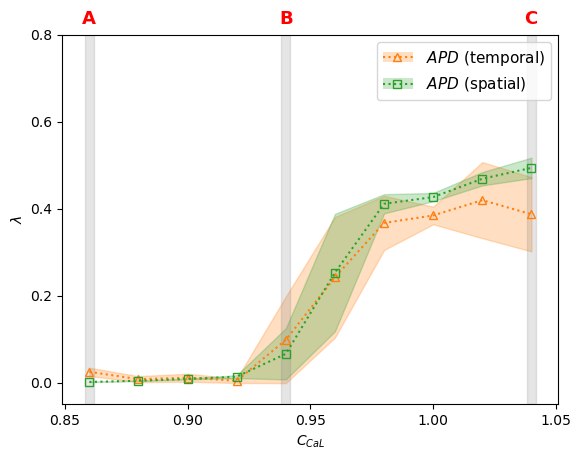

In [14]:

def plot_result(x, y, yerr,C, style=':o', label=None):
    # Convert to numpy arrays
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)
    
    # Plot main line with error bars and legend
    line = plt.errorbar(x, y, yerr=None, color = C,fmt=style, capsize=3, capthick=1, label=label,markerfacecolor='none')
    
    # Plot shaded error region without legend
    plt.fill_between(x, y - yerr, y + yerr, color=line[0].get_color(), alpha=0.25, label='_nolegend_')
    
#plot_result(result_4_tau_r_list,result_uvw,result_uvw_error_total,':^')
plot_result(result_4_tau_r_list,result_APD,result_APD_error_total,'tab:orange',':^')
plot_result(result_4_tau_r_list,result_APD_spatial,result_APD_spatial_error_total,'tab:green',':s')

plt.ylim(-0.05,0.8)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))  # Max 5 ticks on x-axis
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))  # Max 5 ticks on y-axis
#plt.legend([r'$uvw$(temporal)',r'$APD$(temporal)',r'$APD$(spatial)'])
plt.xlabel(r'$C_{CaL}$')
plt.ylabel(r'$\lambda$')
legend = plot_custom_legend()

ylim = plt.ylim()
y_top = ylim[1]
y_text = 1.02 * y_top  # 2% above top

delta = (max(result_4_tau_r_list) - min(result_4_tau_r_list)) /  100# very narrow band width just to highlight the line
for xval, label in zip([0.86  ,0.94,1.04], ['A', 'B', 'C']):
    plt.axvspan(xval - delta, xval + delta, color='gray', alpha=0.2)
    plt.text(xval, y_text, rf'$\mathbf{{{label}}}$', fontsize=13, ha='center', va='bottom',color='red')


plt.savefig('result ovvr.png', dpi=300,bbox_inches='tight')

Text(1.0418, 0.8160000000000001, 'C')

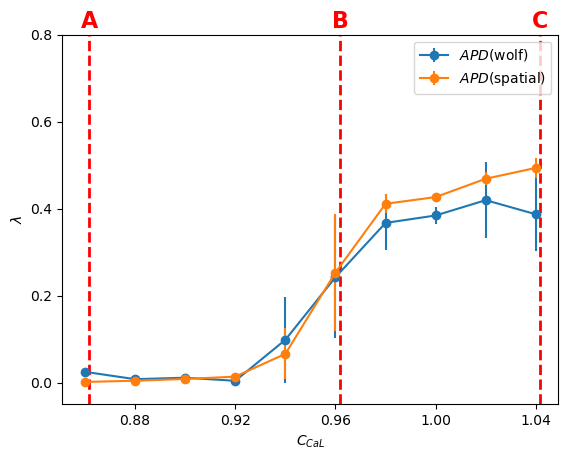

In [11]:
apixel = abs( result_4_tau_r_list[-1] - result_4_tau_r_list[0]) * 0.010
dashline = [0.86 +apixel ,0.96+apixel,1.04+apixel]

#plt.errorbar(result_4_tau_r_list,result_uvw,yerr = result_uvw_error_total, fmt ='-o')
plt.errorbar(result_4_tau_r_list,result_APD,yerr = result_APD_error_total, fmt ='-o')
plt.errorbar(result_4_tau_r_list,result_APD_spatial,yerr = result_APD_spatial_error_total, fmt ='-o')

plt.ylim(-0.05,0.8)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))  # Max 5 ticks on x-axis
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))  # Max 5 ticks on y-axis
#plt.legend([r'$APD$(wolf)',r'$APD$(spatial)'])
plt.xlabel(r'$C_{CaL}$')
plt.ylabel(r'$\lambda$')
#plt.title(r'Simulations$_{<5 times>}$, cost about 2 days ')

plt.axvline(x=dashline[0]  , color='red', linestyle='--', linewidth=2)
plt.axvline(x=dashline[1], color='red', linestyle='--', linewidth=2)
plt.axvline(x=dashline[2] , color='red', linestyle='--', linewidth=2)

# Get current y-limit and use it to place the ABC text slightly above
ylim = plt.ylim()
y_top = ylim[1]
y_text = 1.02 * y_top  # 2% above top

plt.text(dashline[0], y_text, 'A', fontsize=16, fontweight='bold', color='red', ha='center')
plt.text(dashline[1], y_text, 'B', fontsize=16, fontweight='bold', color='red', ha='center')
plt.text(dashline[2], y_text, 'C', fontsize=16, fontweight='bold', color='red', ha='center')

legend = plot_custom_legend()



#plt.savefig('result ovvr new.png', dpi=300,bbox_inches='tight')

In [7]:
# step = 1.6 not 3.2
result_ovvr_uvw_list = []
result_ovvr_APD_list = []


#result_3_tau_pw_list = [250,300,350,400,450]
result_4_C_Na_list = [1]
result_4_repeat_list = ['']
result_4_C_CaL_list = [0.86,0.94,1.04]

for repeat_index,repeat in enumerate(result_4_repeat_list):
    result_ovvr_uvw_list.append([])
    result_ovvr_APD_list.append([])
    for tau_r_index,tau_r in enumerate(result_4_C_CaL_list):
        result_ovvr_uvw_list[repeat_index].append([])
        result_ovvr_APD_list[repeat_index].append([])

        for tau_pw in result_4_C_Na_list:
            print(tau_r)

            tau_pw = str(tau_pw)
            tau_r = str(tau_r)
            path = "F://result_ovvr_C_Na/C_Na_"+ tau_pw + "_C_CaL_" + tau_r + "_spatial_20e4_32e4_8_8_APD_step_1.6" + repeat + ".csv"
            if not os.path.exists(path):
                path = "F://result_ovvr_C_Na/C_Na_"+ tau_pw + "_C_CaL_" + tau_r + "_spatial_20e4_32e4_8_8_APD_step_9.28" + repeat + ".csv"
            APD,V = get_APD_and_voltage_uvw(path,0.5,1.6,True)

            result_ovvr_uvw_list[repeat_index][tau_r_index].append(V)
            result_ovvr_APD_list[repeat_index][tau_r_index].append(APD[0]) # APD = [APD_u,APD_v]

0.86
192
0.94
192
1.04
192


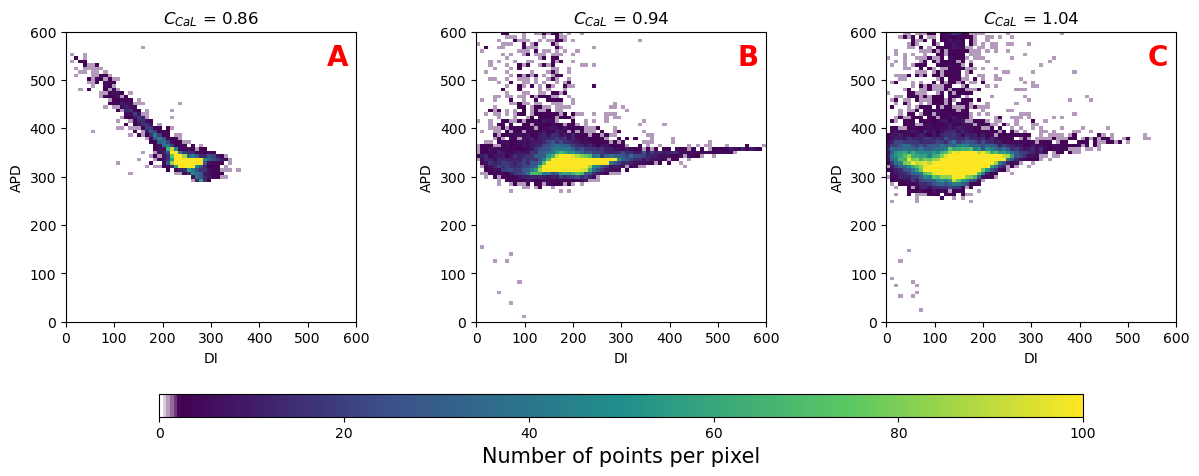

In [8]:
import mpl_scatter_density
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Viridis-like colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0.0, '#ffffff'),
    (0.02, '#440154'),
    (0.25, '#3b518a'),
    (0.5, '#208f8c'),
    (0.75, '#5bc862'),
    (1.0, '#fde724'),
], N=256)

def using_mpl_scatter_density(ax, x, y, v, label, title):
    density = ax.scatter_density(x, y, cmap=white_viridis, dpi=30, vmin=0, vmax=v)
    ax.set_aspect('equal')
    ax.text(0.9, 0.96, label, transform=ax.transAxes, fontsize=20, color='red', fontweight='bold',
            va='top', ha='left')
    ax.set_xlim(0, 600)
    ax.set_ylim(0, 600)
    ax.set_xlabel(r'DI')
    ax.set_ylabel(r'APD')
    ax.set_title(title)
    return density

letters = ['A', 'B', 'C']
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': 'scatter_density'})

# Keep the last density object for the colorbar
densities = []
for idx, (ax, i) in enumerate(zip(axes, [0,1,2])):
    y, x = get_restitution2(result_ovvr_uvw_list[0][i][0][0])
    title = r'$C_{CaL}$ = ' + str(result_4_C_CaL_list[i])
    density = using_mpl_scatter_density(ax, x, y, 100, letters[idx], title)
    densities.append(density)

# Add a single colorbar beneath all plots
cbar = fig.colorbar(
    densities[-1],                   # last artist, all have same scale
    ax=axes,                         # reference all axes
    orientation='horizontal',
    fraction=0.06,                   # relative size of colorbar
    pad=0.15,                        # space between subplots and colorbar
    aspect=40,                       # length vs. width ratio
)
cbar.set_label('Number of points per pixel', fontsize=15)

plt.subplots_adjust(bottom=0.3)  # Increase bottom space as needed
plt.savefig('OVVR rest curve.png', dpi=300, bbox_inches='tight')
plt.show()